<a href="https://colab.research.google.com/github/KN196883/bond_pricer/blob/master/FIXED_BOND_PRICER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Python class and jupyter iPython notebook for pricing a fixed coupon bond

In [47]:
import pandas as pd
import numpy as np
import math as m
import datetime as dt
from dateutil.relativedelta import relativedelta
import calendar

##################################################################################
#Adding daycount convention functions
##################################################################################
def day_count_actual_360(start_date, end_date):
    #Returns number of days between start_date and end_date, using Actual/360 convention
    return (end_date - start_date).days

def day_count_actual_365(start_date, end_date):
    #Returns number of days between start_date and end_date, using Actual/365 convention
    return (end_date - start_date).days

def day_count_actual_actual(start_date, end_date):
    #Returns number of days between start_date and end_date, using Actual/Actual convention
    return (end_date - start_date).days

def day_count_30_360(start_date, end_date):
    #Returns number of days between start_date and end_date, using Thirty/360 convention
    d1 = min(30, start_date.day)
    d2 = min(d1, end_date.day) if d1 == 30 else end_date.day
    return 360*(end_date.year - start_date.year) + 30*(end_date.month - start_date.month) + d2 - d1

def day_count_30E_360(start_date, end_date):
    #Returns number of days between start_date and end_date, using ThirtyE/360 convention
    d1 = min(30, start_date.day)
    d2 = min(30, end_date.day)
    return 360 * (end_date.year - start_date.year) + 30 * (end_date.month - start_date.month) + d2 - d1





#######################################################################
#月末日計算(2/28応答日用)
#######################################################################

def get_last_date(dt):
    return dt.replace(day=calendar.monthrange(dt.year, dt.month)[1])




  

class fixed_bond:
    def __init__(self, issue_date, settlement_date, first_coupon_date, maturity_date, face_value, reoffer_yield, coupon_rate, first_coupon_type, coupon_frequency, day_count_convention, redemption_rate):
        ##################################################################################
        #Setting up inital attributes
        ##################################################################################
        self.issue_date = issue_date
        self.settlement_date = settlement_date
        self.first_coupon_date = first_coupon_date
        self.maturity_date = maturity_date
        self.face_value = face_value
        self.reoffer_yield = reoffer_yield
        self.coupon_rate = coupon_rate
        self.first_coupon_type = first_coupon_type
        self.coupon_frequency = coupon_frequency
        self.day_count_convention = day_count_convention
        self.redemption_rate = redemption_rate

        ##################################################################################
        #Parsing input values
        ##################################################################################
        #Converting reoffer yield to percentage
        self.reoffer_yield = self.reoffer_yield/100

        #Converting coupon rate to percentage
        self.coupon_rate = self.coupon_rate/100

        #parsing coupon frequency
        if self.coupon_frequency == "ANNUAL":
            self.coupon_frequency_modifier = 1
        elif self.coupon_frequency == "SEMI-ANNUAL":
            self.coupon_frequency_modifier = 2
        elif self.coupon_frequency == "QUARTERLY":
            self.coupon_frequency_modifier = 4
        elif self.coupon_frequency_modifier == "MONTHLY":
            self.coupon_frequency_modifier = 12
        else:
            self.coupon_frequency_modifier = 1
            #need to add error handling

        #Converting redemption rate to percentage
        self.redemption_rate = self.redemption_rate/100

        #Generating accrual start date
        time_modifier = int(12/self.coupon_frequency_modifier)

        # if self.first_coupon_type == "REGULAR":
        #     self.accrual_start_date = self.settlement_date
        # else:
        #     self.accrual_start_date = self.first_coupon_date - relativedelta(months=time_modifier)

        self.accrual_start_date=self.first_coupon_date-relativedelta(months=time_modifier)


        ##################################################################################
        #Generating the columns for the cash flow table
        ##################################################################################
        #generating cash flow schedule
        cash_flow_date = self.first_coupon_date
        cash_flow_dates = [cash_flow_date]
        self.number_of_periods = 1


        ######ここから
        if cash_flow_date==get_last_date(cash_flow_date):
          eom=1
        else:
          eom=0        
      

        while cash_flow_date < maturity_date:
            cash_flow_date += relativedelta(months=time_modifier)
            if eom==1:
              cash_flow_date=get_last_date(cash_flow_date)

            cash_flow_dates.append(cash_flow_date)
            self.number_of_periods += 1

        self.cash_flow_dates = cash_flow_dates

      #######ここ


        #computing cash flow periods
        cash_flow_periods = []
        for i in range(self.number_of_periods):
            cash_flow_periods.append(i + 1)
        self.cash_flow_periods = cash_flow_periods

        # computing future cash flows per date
        self.coupon_payment = (self.face_value*self.coupon_rate)/self.coupon_frequency_modifier
        self.principal_payment = self.face_value * self.redemption_rate

        cash_flow_amounts = []
        for i in range(self.number_of_periods):
            if i == self.number_of_periods - 1:
                cash_flow = self.principal_payment + self.coupon_payment
            else:
                cash_flow = self.coupon_payment

            cash_flow_amounts.append(cash_flow)
        self.cash_flow_amounts = cash_flow_amounts

        #Computing discount rate
        self.discount_rate = 1 + (self.reoffer_yield/self.coupon_frequency_modifier)
        self.discount_rates = []
        for i in range(self.number_of_periods):
            self.discount_rates.append(self.discount_rate)

        #Computing discount period
        if self.first_coupon_type == "REGULAR":
            self.discount_period = 1
            accrued_numerator = day_count_actual_actual(self.accrual_start_date,self.settlement_date)
            denominator = day_count_actual_actual(self.accrual_start_date,self.first_coupon_date)
            accrued_denominator = denominator
            self.accrued_period = accrued_numerator/accrued_denominator
            self.accrued_days = accrued_numerator        
            self.accrued_interest = self.cash_flow_amounts[0]*self.accrued_period



        else:
            if self.day_count_convention == "ACTUAL/ACTUAL":
                numerator = day_count_actual_actual(self.settlement_date,self.first_coupon_date)
                denominator = day_count_actual_actual(self.accrual_start_date,self.first_coupon_date)
                self.discount_period = numerator/denominator
                if self.first_coupon_type == "FULL SHORT FIRST":
                    accrued_numerator = day_count_actual_actual(self.accrual_start_date,self.settlement_date)
                    accrued_denominator = denominator
                    self.accrued_period = accrued_numerator/accrued_denominator
                    self.accrued_days = accrued_numerator
                    self.accrued_interest = self.cash_flow_amounts[0]*self.accrued_period
                else:
                    self.accrued_period = 0
                    self.accrued_days = 0
                    self.accrued_interest = 0

            elif self.day_count_actual_365 == "ACTUAL/365":
                numerator = day_count_actual_365(self.settlement_date,self.first_coupon_date)
                denominator = 365/self.coupon_frequency_modifier
                self.discount_period = numerator/denominator
                if self.first_coupon_type == "FULL SHORT FIRST":
                    accrued_numerator = day_count_actual_actual(self.accrual_start_date,self.settlement_date)
                    accrued_denominator = denominator
                    self.accrued_period = accrued_numerator/accrued_denominator
                    self.accrued_days = accrued_numerator
                    self.accrued_interest = self.cash_flow_amounts[0]*self.accrued_period
                else:
                    self.accrued_period = 0
                    self.accrued_days = 0
                    self.accrued_interest = 0

            elif self.day_count_actual_360 == "ACTUAL/360":
                numerator = day_count_actual_360(self.settlement_date,self.first_coupon_date)
                denominator = 360/self.coupon_frequency_modifier
                self.discount_period = numerator/denominator
                if self.first_coupon_type == "FULL SHORT FIRST":
                    accrued_numerator = day_count_actual_actual(self.accrual_start_date,self.settlement_date)
                    accrued_denominator = denominator
                    self.accrued_period = accrued_numerator/accrued_denominator
                    self.accrued_days = accrued_numerator
                    self.accrued_interest = self.cash_flow_amounts[0]*self.accrued_period
                else:
                    self.accrued_period = 0
                    self.accrued_days = 0
                    self.accrued_interest = 0

            elif self.day_count_30_360 == "30/360":
                numerator = day_count_30_360(self.settlement_date,self.first_coupon_date)
                denominator = 360/coupon_frequency_modifier
                self.discount_period = numerator/denominator
                if self.first_coupon_type == "FULL SHORT FIRST":
                    accrued_numerator = day_count_actual_actual(self.accrual_start_date,self.settlement_date)
                    accrued_denominator = denominator
                    self.accrued_period = accrued_numerator/accrued_denominator
                    self.accrued_days = accrued_numerator
                    self.accrued_interest = self.cash_flow_amounts[0]*self.accrued_period
                else:
                    self.accrued_period = 0
                    self.accrued_days = 0
                    self.accrued_interest = 0

            elif self.day_count_30E_360 == "30E/360":
                numerator = day_count_30E_360(self.settlement_date,self.first_coupon_date)
                denominator = 360/coupon_frequency_modifier
                self.discount_period = numerator/denominator
                if self.first_coupon_type == "FULL SHORT FIRST":
                    accrued_numerator = day_count_actual_actual(self.accrual_start_date,self.settlement_date)
                    accrued_denominator = denominator
                    self.accrued_period = accrued_numerator/accrued_denominator
                    self.accrued_days = accrued_numerator
                    self.accrued_interest = self.cash_flow_amounts[0]*self.accrued_period
                else:
                    self.accrued_period = 0
                    self.accrued_days = 0
                    self.accrued_interest = 0
        
        self.discount_periods = []
        for i in range(self.number_of_periods):
            self.discount_periods.append(self.discount_period+i)

        #Adjusting first coupon if it's a full short first
        if self.first_coupon_type == "FULL SHORT FIRST":
            self.cash_flow_amounts[0] = self.coupon_payment
        elif self.first_coupon_type != "REGULAR":
            self.cash_flow_amounts[0] = self.coupon_payment * self.discount_period

        #generating a cash flow table and calculating reoffer cash price
        #table - coupon number / coupon date / cash flow / discount rate / discount period / npv
        df = pd.DataFrame(np.column_stack([self.cash_flow_periods, self.cash_flow_dates, self.cash_flow_amounts, self.discount_rates, self.discount_periods]), 
                               columns=['coupon number', 'coupon_date', 'cash_flow', 'discount_rate', 'discount_period'])
        df['npv'] = (df.cash_flow / (df.discount_rate**df.discount_period))

        self.cash_flow_table = df
        self.reoffer_price = (self.cash_flow_table.npv.sum()/self.face_value)*100
        self.dirty_price = self.reoffer_price + (self.accrued_interest/self.face_value)

In [48]:
##################################################################################
#Using the class
##################################################################################
issue_date = dt.date(2021,2,16)
settlement_date = dt.date(2021,2,26)
first_coupon_date = dt.date(2021,8,15)
maturity_date = dt.date(2031,2,15)
face_value = 1000
reoffer_yield = 1.399
coupon_rate = 1.125
first_coupon_type = "REGULAR"
coupon_frequency = "SEMI-ANNUAL"
day_count_convention = "ACTUAL/ACTUAL"
redemption_rate = 100

test_bond = fixed_bond(issue_date,settlement_date,first_coupon_date, maturity_date,face_value,reoffer_yield,coupon_rate,first_coupon_type,coupon_frequency,day_count_convention,redemption_rate)

print(test_bond.cash_flow_table)
print(f"Reoffer clean price is: {round(test_bond.reoffer_price,3)}%")
print(f"Days of accrued interest: {test_bond.accrued_days}")
print(f"Reoffer dirty price is: {round(test_bond.dirty_price,3)}%")

##################################################################################
#List of inputs
##################################################################################
#issue_date, settlement_date, first_coupon_date,maturity_date = datetime objects (yyyy,m,d)
#face_value = float
#reoffer_yield = for example, a reoffer yield of 2.3% is entered as 2.3
#coupon_rate = for example, a coupon of 2.25% is entered as 2.25
#first_coupon_type = string: REGULAR, ODD, FULL SHORT FIRST
#coupon_frequency = string: ANNUAL, SEMI-ANNUAL, QUARTERLY, MONTHLY
#day_count_convention = string: ACTUAL/ACTUAL, ACTUAL/365, ACTUAL/360, 30/360, 30E/360
#redemption_rate = for example, a redemption rate of 100% is entered as 100

   coupon number coupon_date cash_flow discount_rate discount_period      npv
0              1  2021-08-15     5.625         1.007               1  5.58593
1              2  2022-02-15     5.625         1.007               2  5.54712
2              3  2022-08-15     5.625         1.007               3  5.50859
3              4  2023-02-15     5.625         1.007               4  5.47033
4              5  2023-08-15     5.625         1.007               5  5.43233
5              6  2024-02-15     5.625         1.007               6  5.39459
6              7  2024-08-15     5.625         1.007               7  5.35712
7              8  2025-02-15     5.625         1.007               8  5.31991
8              9  2025-08-15     5.625         1.007               9  5.28295
9             10  2026-02-15     5.625         1.007              10  5.24625
10            11  2026-08-15     5.625         1.007              11  5.20981
11            12  2027-02-15     5.625         1.007            

In [49]:
##################################################################################
#Using the class
##################################################################################
issue_date = dt.date(2021,2,16)
settlement_date = dt.date(2021,3,1)
first_coupon_date = dt.date(2021,8,15)
maturity_date = dt.date(2031,2,15)
face_value = 1000
reoffer_yield = 1.405
coupon_rate = 1.125
first_coupon_type = "REGULAR"
coupon_frequency = "SEMI-ANNUAL"
day_count_convention = "ACTUAL/ACTUAL"
redemption_rate = 100

test_bond = fixed_bond(issue_date,settlement_date,first_coupon_date, maturity_date,face_value,reoffer_yield,coupon_rate,first_coupon_type,coupon_frequency,day_count_convention,redemption_rate)

print(test_bond.cash_flow_table)
print(f"Reoffer clean price is: {round(test_bond.reoffer_price,3)}%")
print(f"Days of accrued interest: {test_bond.accrued_days}")
print(f"Reoffer dirty price is: {round(test_bond.dirty_price,3)}%")

##################################################################################
#List of inputs
##################################################################################
#issue_date, settlement_date, first_coupon_date,maturity_date = datetime objects (yyyy,m,d)
#face_value = float
#reoffer_yield = for example, a reoffer yield of 2.3% is entered as 2.3
#coupon_rate = for example, a coupon of 2.25% is entered as 2.25
#first_coupon_type = string: REGULAR, ODD, FULL SHORT FIRST
#coupon_frequency = string: ANNUAL, SEMI-ANNUAL, QUARTERLY, MONTHLY
#day_count_convention = string: ACTUAL/ACTUAL, ACTUAL/365, ACTUAL/360, 30/360, 30E/360
#redemption_rate = for example, a redemption rate of 100% is entered as 100

   coupon number coupon_date cash_flow discount_rate discount_period      npv
0              1  2021-08-15     5.625       1.00703               1  5.58576
1              2  2022-02-15     5.625       1.00703               2  5.54679
2              3  2022-08-15     5.625       1.00703               3   5.5081
3              4  2023-02-15     5.625       1.00703               4  5.46967
4              5  2023-08-15     5.625       1.00703               5  5.43152
5              6  2024-02-15     5.625       1.00703               6  5.39363
6              7  2024-08-15     5.625       1.00703               7    5.356
7              8  2025-02-15     5.625       1.00703               8  5.31864
8              9  2025-08-15     5.625       1.00703               9  5.28154
9             10  2026-02-15     5.625       1.00703              10  5.24469
10            11  2026-08-15     5.625       1.00703              11  5.20811
11            12  2027-02-15     5.625       1.00703            

In [50]:
test_bond.accrued_interest

0.43508287292817677

In [51]:
#Githubのcsvをurlから読み込み
import urllib.request
from io import StringIO

url = 'https://raw.githubusercontent.com/KN196883/bond_pricer/master/usbondall2.csv'

#csvを読み込む関数
def read_csv(url):
    print(url)
    res = urllib.request.urlopen(url)
    res = res.read().decode("utf-8")
    df = pd.read_csv(StringIO( res) )
    return df

#実行
df=read_csv(url)
df=df.drop(['発行体名','Unnamed: 16'],axis=1)

https://raw.githubusercontent.com/KN196883/bond_pricer/master/usbondall2.csv


In [59]:
priceDF=pd.read_csv('https://raw.githubusercontent.com/KN196883/bond_pricer/master/data0304',sep='\t',
                    names=('cusip','coupon','maturity','price','yield'))
priceDF

,cusip,coupon,maturity,price,yield
0,912796C23 GOVT,0.000,2021-03-02,0.019678,0.026468
1,9127964F3 GOVT,0.000,2021-03-04,0.026361,0.029406
2,912796C72 GOVT,0.000,2021-03-09,0.022438,0.024445
3,9127964M8 GOVT,0.000,2021-03-11,0.028178,0.029256
4,912796C80 GOVT,0.000,2021-03-16,0.024862,0.026902
...,...,...,...,...,...
900,912810SL3 GOVT,2.000,2050-02-15,93.9375,2.289643
901,912810SN9 GOVT,1.250,2050-05-15,77.54688,2.313866
902,912810SP4 GOVT,1.375,2050-08-15,80.13281,2.309977
903,912810SS8 GOVT,1.625,2050-11-15,85.48438,2.303690


In [32]:
#日付の型変換

df_t=df[df['ﾃｨｯｶｰ']=='T'].sort_values('f_maturity').reset_index(drop=True)
tran_list=['満期','初回利払日','前回利払日','次回利払日','発行日','f_maturity']

for i in tran_list:
  df_t[i]=pd.to_datetime(df_t[i])


In [33]:
#CFに合わせて銘柄を選択

import itertools

list_mat=set(df_t['f_maturity'])

reqd_index=[]

for i in list_mat:
  temp_list_mat=df_t[df_t['f_maturity']==i]['発行日']
  new_issue=max(temp_list_mat)
  ind=df_t[(df_t['f_maturity']==i) & (df_t['発行日']==new_issue)].index.tolist()
  reqd_index.append(ind)

reqd_index=list(itertools.chain.from_iterable(reqd_index))

df_select=df_t.reindex(index=reqd_index).sort_values('f_maturity')
df_select=df_select[df_select['f_maturity']<='2031-2-28']


list_mat=set(df_select['f_maturity'])


In [34]:
settlement_date = dt.date(2021,2,26)

cashflow_list=[]
cleanprice_list=[]

for row in df_select.itertuples():

  issue_date = dt.date(row.発行日.year,row.発行日.month,row.発行日.day)
  first_coupon_date = dt.date(row.次回利払日.year,row.次回利払日.month,row.次回利払日.day)
  maturity_date = dt.date(row.f_maturity.year,row.f_maturity.month,row.f_maturity.day)
  face_value = 100
  reoffer_yield = row.bval_y
  coupon_rate = row.f_coupon
  first_coupon_type = "REGULAR"
  coupon_frequency = "SEMI-ANNUAL"
  day_count_convention = "ACTUAL/ACTUAL"
  redemption_rate = 100

  test_bond = fixed_bond(issue_date,settlement_date,first_coupon_date, maturity_date,face_value,reoffer_yield,coupon_rate, first_coupon_type,coupon_frequency,day_count_convention,redemption_rate)
  
  cashflow_list.append([test_bond.cash_flow_dates,test_bond.cash_flow_amounts])
  cleanprice_list.append(test_bond.reoffer_price)

#clean priceのソースを何にするか・・・
cleanprice_list2=cleanprice_list
cleanprice_list=df_select['bval_p'].values.tolist()

In [35]:
list_mat=list(map(lambda x:dt.date(x.year,x.month,x.day),list(list_mat)))
list_mat=sorted(list_mat)

In [36]:
cashflow_matrix=[]
extend_cashflow=[0]*len(list_mat)

test_cashflow=cashflow_list[100]

for j in range(len(cashflow_list)):

    for i in range(len(cashflow_list[j][0])):
        h=list_mat.index(cashflow_list[j][0][i])
        extend_cashflow[h]=cashflow_list[j][1][i]

    cashflow_matrix.append(extend_cashflow)
    extend_cashflow=[0]*len(list_mat)

extend_cashflow=np.array(extend_cashflow)

In [37]:
inv_cashflow_matrix=np.linalg.inv(cashflow_matrix)
discountF_list=np.dot(np.linalg.inv(cashflow_matrix),cleanprice_list)

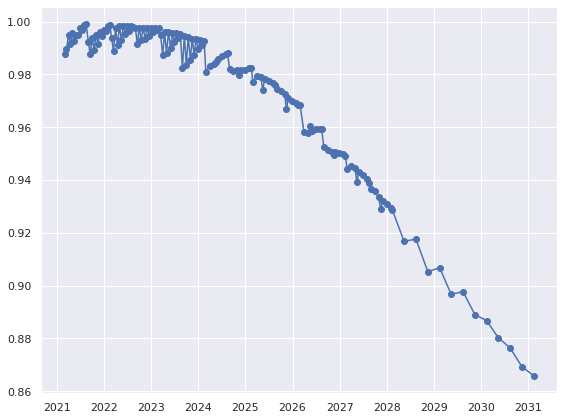

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

x=list_mat
y=discountF_list

plt.plot_date(x, y,linestyle ='solid')
plt.gcf().set_size_inches(8, 6)
plt.tight_layout()
plt.show()

In [39]:
def yield_to_price(y,coupon,remaining):
    x=(1+y/200)^(2*remaining)
    price=(coupon*100/y)*(x-1)/x+100/x
    return price


def calc_reamainig(settle,maturity):
    n=settle-maturity
    return n


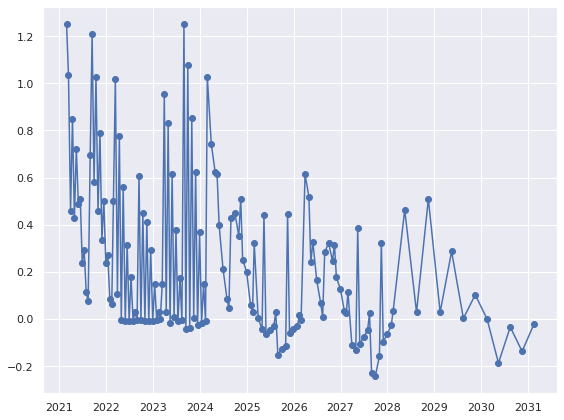

In [40]:
x=list_mat
y=np.array(cleanprice_list2)-np.array(cleanprice_list)

plt.plot_date(x, y,linestyle ='solid')
plt.gcf().set_size_inches(8, 6)
plt.tight_layout()
plt.show()

In [41]:
#df['f_cusip'].to_csv('cusip.csv')